In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import requests
import torch
import os 
from sklearn.model_selection import train_test_split

from textwrap import wrap

In [2]:
path = './data/polyvore_outfits/polyvore_item_metadata.json'
with open(path, 'r') as f:
    data = json.load(f)

In [3]:
len(list(data.keys()))

251008

In [4]:
def train_val_test_split(X, y, train_ratio, validation_ratio, test_ratio, random_state = 42, stratify = None):
    test_size = 1 - train_ratio # we first split into a train set and a val+test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state, stratify = stratify)
    test_size = test_ratio/(test_ratio + validation_ratio) # We then compute how the val+test set data should be split
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_size, random_state = random_state, stratify = stratify) 
    return X_train, X_val, X_test, y_train, y_val, y_test

In [5]:
path = './data/'
os.listdir(path)

['sydney_captions',
 'scicap_data.zip',
 'polyvore',
 'scicap',
 'fashion200k',
 'UCM_captions.zip',
 'RSICD.zip',
 'polyvore-images.tar.gz',
 'RSICD',
 'UCM',
 'UCMerced_LandUse',
 'WHU-RS19',
 'RSSCN7',
 'AID',
 'NWPU-RESISC45',
 'kaggle_simpsons_characters.zip',
 'kaggle_simpsons_characters',
 'polyvore_outfits.zip',
 'polyvore_outfits',
 'fashiongen',
 'test',
 '.ipynb_checkpoints']

In [6]:
%%time
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

CPU times: user 7.49 s, sys: 553 ms, total: 8.04 s
Wall time: 2.26 s


In [7]:
def clip_predict_label(images, labels):
    inputs = processor(text=labels, images=images, return_tensors="pt", padding=True)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities
    max_prob_ind = np.argmax(probs.detach().numpy(), axis = 1)
    return np.array(labels)[max_prob_ind]

In [8]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
images = [image] * 8

In [9]:
%%time
labels = ["a cat", "a dog", "a horse", "an elephant", "a rat"]
labels = ['an image of ' + l for l in labels]
print('Number of labels:', len(labels))
clip_predict_label(images, labels)

Number of labels: 5
CPU times: user 25.5 s, sys: 26.1 ms, total: 25.5 s
Wall time: 1.19 s


array(['an image of a cat', 'an image of a cat', 'an image of a cat',
       'an image of a cat', 'an image of a cat', 'an image of a cat',
       'an image of a cat', 'an image of a cat'], dtype='<U23')

# Fashion200k

In [10]:
path = './data/fashion200k/labels/'
txt_files = os.listdir(path)
entries = []
for txt_file in txt_files:
    with open(os.path.join(path, txt_file), 'r') as f:
        data = f.readlines()
    entries += data
print('Number of (captioned/labeled) images:', len(entries))

Number of (captioned/labeled) images: 201838


In [11]:
entries_dict = {}
for entry in entries:
    entry = entry.split('\t')
    entry_path = entry[0].split('/')
    entry_path.pop(3)
    entries_dict['/'.join(entry_path)] = entry[1:]

In [12]:
# Computing number of fashion200k images when we don't count images of the same item 
keys = list(entries_dict.keys())
keys = [k.split('/')[-1].split('_')[0] for k in keys]
print('Number of non-duplicate images in Fashion200k:', len(set(keys)))

Number of non-duplicate images in Fashion200k: 72419


Number of main clothing categories: 2
women/skirts/mini_skirts/91251936_3.jpeg
91251936


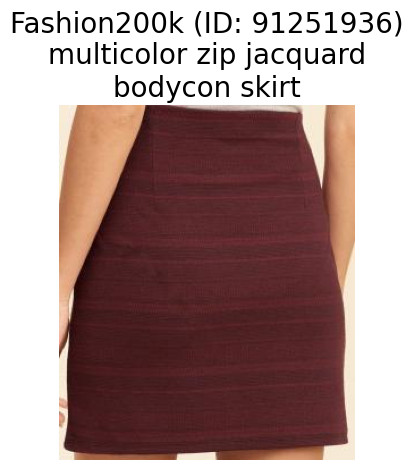

In [13]:
# %%time
path = './data/fashion200k/'

# First, get the main fashion categories (e.g. dresses, skirts, pants)
categories = os.listdir(path)
N = len(categories)
print('Number of main clothing categories:', N)

img_paths = list(entries_dict.keys())
img_paths = [p for p in img_paths if '91251936_3' in p]
example_img = np.random.choice(img_paths) # Pick a random image
print(example_img)
img_path = os.path.join(path, example_img)
image = Image.open(img_path)
img_path = img_path.replace(path, '')
img_id = img_path.split('/')[-1][:-7]
print(img_id)
# Plot the random image example
plt.imshow(image)
plt.axis('off')

description = entries_dict[img_path][-1]
title = 'Fashion200k (ID: {})\n{}'.format(img_id, '\n'.join(wrap(description, 25)))
plt.title(title, fontsize = 20)
plt.tight_layout()
plt.savefig('./images/fashion200k_example.png', transparent = True, bbox_inches='tight')

In [14]:
path = './data/fashion200k/'
values = [tuple(e.split('\t')) for e in entries]
img_paths = [v[0] for v in values]
img_paths = ['/'.join(np.array(i.split('/'))[[0,1,2,4]]) for i in img_paths]
image_paths = np.random.choice(img_paths, size = 100, replace = False)
images = [Image.open(os.path.join(path,i)) for i in image_paths]

In [15]:
target_img = img_path.split('/')[-1]
for i, p in enumerate(img_paths):
    if target_img in p:
        print(p, values[i][-1])

women/skirts/mini_skirts/91251936_3.jpeg multicolor zip jacquard bodycon skirt



In [16]:
# The categories returned by our os.walk above contains both the main categories as well as their subcategories
subcategories = False
# Here, we make a choice to either only use the subcategories as labels, or only the main labels
labels = categories[5:] if subcategories else categories[:5]
# Remove underscores ('_')
labels = [l.replace('_', ' ') for l in labels]
# Remove trailing '(e)s' from the names (e.g. shirts -> shirt, dresses -> dress)
# Exeptions are to make sure we don't get blouses -> blous and not pants -> pant
labels = [l[:-2] if l.endswith('es') and l != 'blouses' else l[:-1] if 'pant' not in l else l for l in labels]
labels = ['an image of a ' + l for l in labels]
print(labels)

# Here we get the true labels of the images based on their paths
# The paths look like './data/fashion200k/women/main_category/subcategory', so we split on '/' to get the folder structure
# In this folder structure index 4 is for the main categories and 5 is for the subcategories
category_ind = 1 if subcategories else 2
true_labels = [p.split('/')[category_ind] for p in image_paths]

['an image of a label', 'an image of a wome']


In [17]:
# Show the true labels
print(true_labels)

['leather_jackets', 'short_sleeve_tops', 'leather_jackets', 'cropped_pants', 'shirts', 'mini_and_short_dresses', 'denim_jackets', 'cocktail_dresses', 'gowns', 'prom_and_formal_dresses', 'padded_and_down_jackets', 'mini_skirts', 'casual_and_day_dresses', 'prom_and_formal_dresses', 'casual_and_day_dresses', 'fur_jackets', 'maxi_and_long_dresses', 'blouses', 'short_sleeve_tops', 'mini_skirts', 'full_length_pants', 'cropped_pants', 'casual_and_day_dresses', 'maxi_skirts', 'long_sleeved_tops', 'wide-leg_and_palazzo_pants', 'long_sleeved_tops', 'knee_length_skirts', 'cropped_pants', 't-shirts', 'mini_and_short_dresses', 'knee_length_skirts', 'gowns', 'short_sleeve_tops', 'mid_length_skirts', 'maxi_and_long_dresses', 'mid_length_skirts', 'blouses', 'blazers_and_suit_jackets', 'prom_and_formal_dresses', 'cocktail_dresses', 'gowns', 'maxi_skirts', 'knee_length_skirts', 'casual_and_day_dresses', 'cropped_pants', 'maxi_skirts', 'waistcoats_and_gilets', 'long_sleeved_tops', 'cropped_pants', 'cropp

CPU times: user 49.8 s, sys: 6.39 s, total: 56.2 s
Wall time: 3.65 s


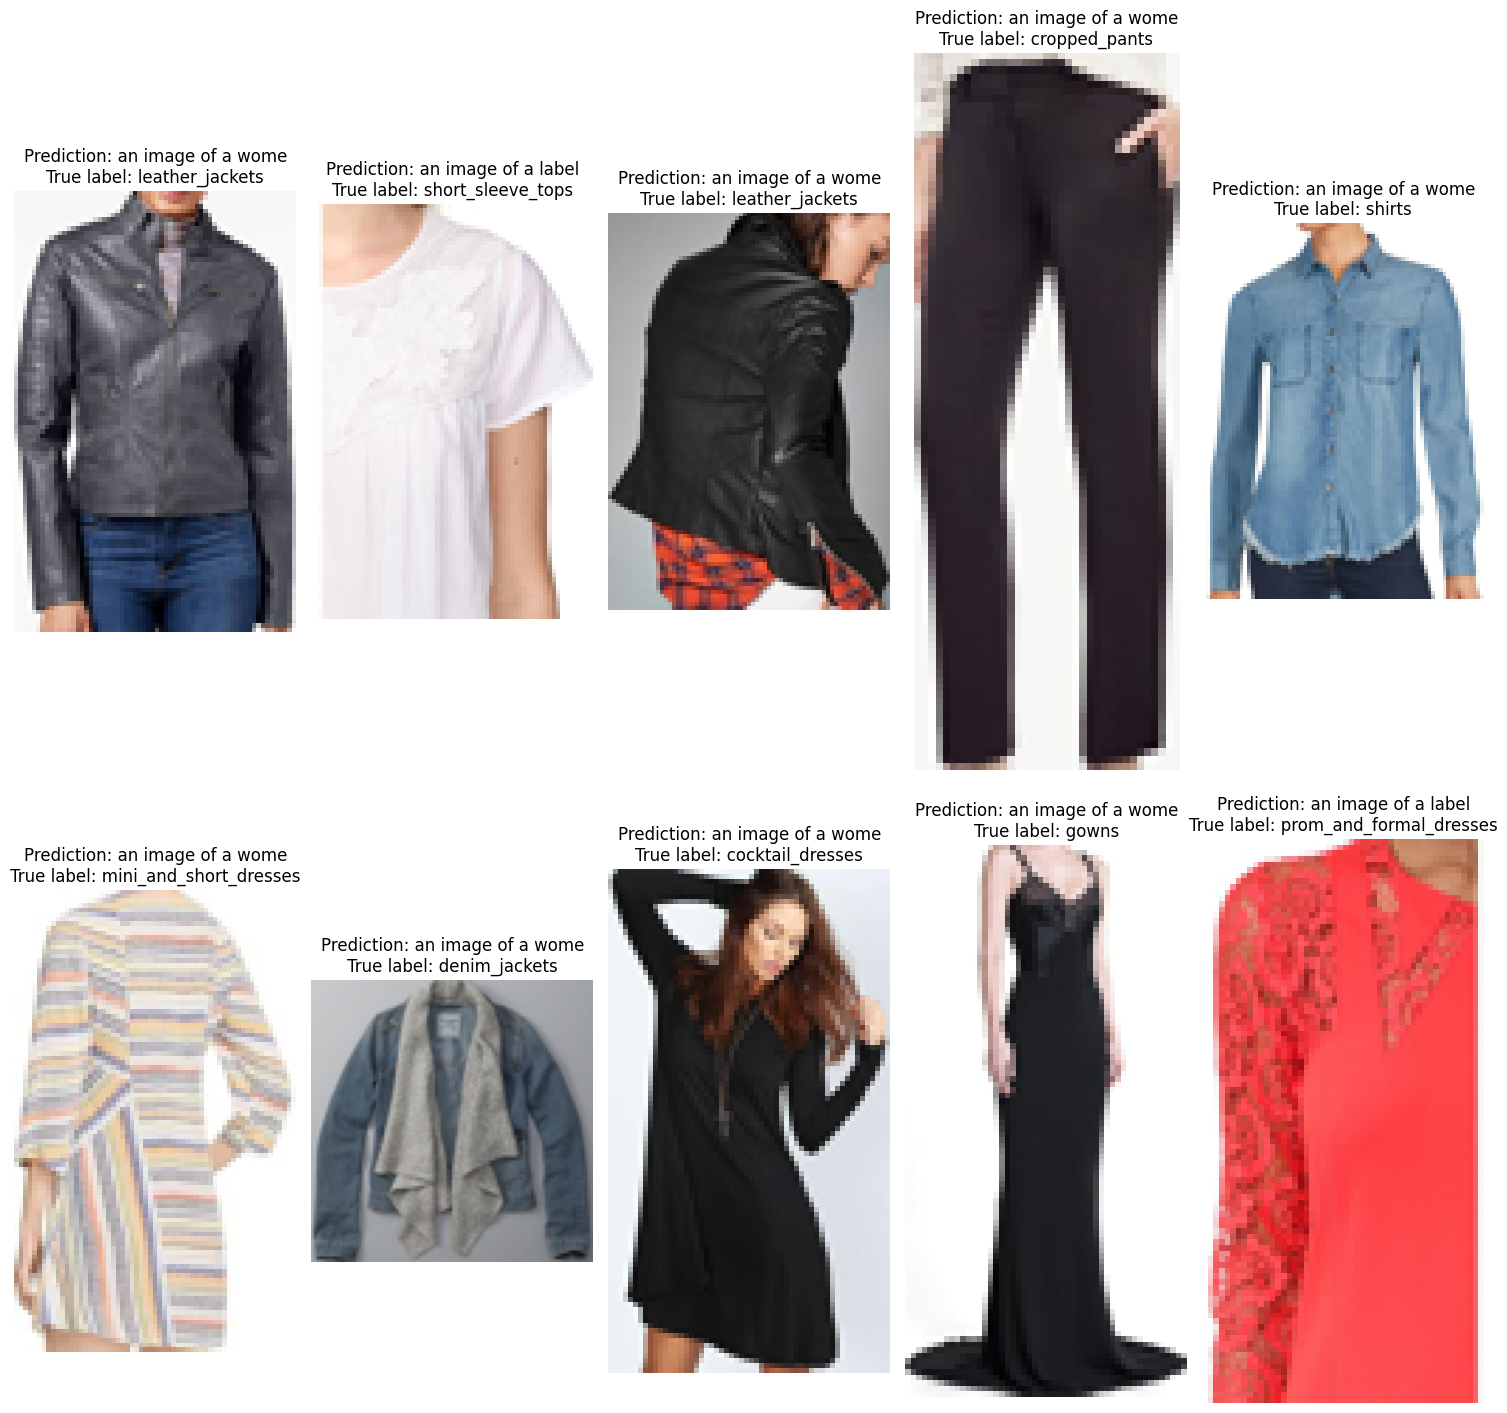

In [18]:
%%time
predicted_labels = clip_predict_label(images, labels)
num_pred = len(predicted_labels)
max_plots = 10
n_rows = 2
fig, ax = plt.subplots(nrows=n_rows, ncols=min(max_plots, num_pred)//n_rows, figsize=(15,15))
r, c = 0, 0
for i in range(min(max_plots,num_pred)):
    img, pred, label = images[i], predicted_labels[i], true_labels[i]
    (width, height) = (img.width * 100//img.height, 100)
    img = img.resize((width, height))
    ax[r, c].imshow(img)
    ax[r, c].set_title('Prediction: {}\nTrue label: {}'.format(pred, label))
    ax[r, c].axis('off')
    c += 1
    if c >= min(max_plots, num_pred)//n_rows:
        r += 1
        c = 0
plt.tight_layout()

# Polyvore

In [19]:
import json
path = './data/polyvore_outfits/polyvore_item_metadata.json'
with open(path, 'r') as f:
    json_file = json.load(f)

Number of images: 251008
183425571


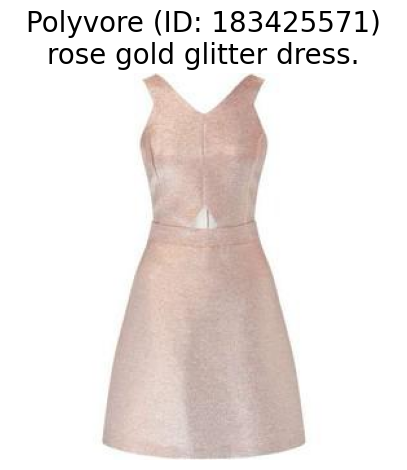

In [20]:
keys = list(json_file.keys())
print('Number of images:', len(keys))
random_key = str(183425571) #np.random.choice(keys)
print(random_key)
item = json_file[random_key]
description = item["url_name"] + ". " #+ item["title"] + ". " + item["description"]
img_path = './data/polyvore_outfits/images/' + random_key + '.jpg'
image = Image.open(img_path)

# Plot the random image example
plt.imshow(image)
plt.axis('off')
title = 'Polyvore (ID: {})\n{}'.format(random_key, '\n'.join(wrap(description, 25)))
plt.title(title, fontsize = 20)
plt.tight_layout()
plt.savefig('./images/polyvore_outfits_example.jpg', transparent = True, bbox_inches='tight')

# FashionGen

Number of images: 260490
104768
Pink Logo Sandals Calfskin slip-on sandals in pink. Round open toe. Glossy black logo at strap. Rubber sole. Tonal stitching.


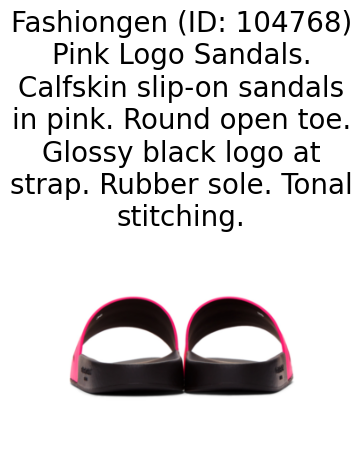

In [21]:
import h5py
path = './data/fashiongen'
split = 'train'
h5_path = os.path.join(path, f"fashiongen_256_256_{split}.h5") # hdf5
h5_file = h5py.File(h5_path)
images = h5_file['input_image']
names = h5_file['input_name']
descriptions = h5_file['input_description']
print('Number of images:', len(images))
idx = 104768 #np.random.choice(len(images))
print(idx)
img = images[idx]
name, description = names[idx][0].decode('latin-1'), descriptions[idx][0].decode('latin-1')
full_name = name + '. ' + description
print(name, description)
plt.imshow(img)
plt.axis('off')
title = 'Fashiongen (ID: {})\n{}'.format(idx, '\n'.join(wrap(full_name , 25)))
plt.title(title, fontsize = 20)
plt.tight_layout()
plt.savefig('./images/fashiongen_outfits_example.jpg', transparent = True, bbox_inches='tight')

# SciCap

Number of captions: 333442
Train images: 106834
Image caption: Fig. 8 Packed Spectrum of the VOIP Signal


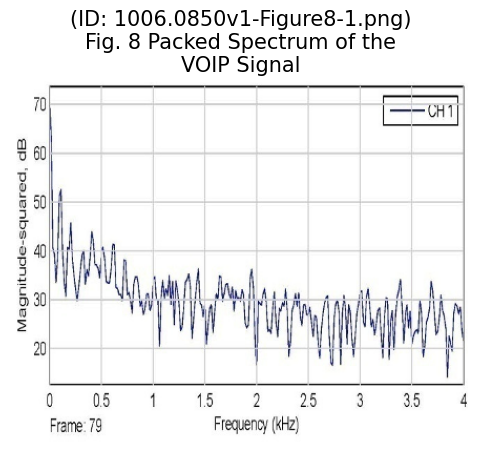

In [36]:
# Acquire all train images WITHOUT subfigures (like S-CLIP paper does)
img_path = './data/scicap/SciCap-No-Subfig-Img/train'
train_images = os.listdir(img_path)
random_idx = np.random.randint(len(train_images))
example_img = '1006.0850v1-Figure8-1.png' #train_images[random_idx]
image = Image.open(os.path.join(img_path, example_img))

# Contains captions of all train instances (with and without subfigures)
caption_path = './data/scicap/SciCap-Caption-All/train'
train_captions = os.listdir(caption_path)
example_caption = example_img.replace('.png', '') + '.json'
with open(os.path.join(caption_path, example_caption), 'r') as f:
    data = json.load(f)
    
# Print + plot some statistics
caption = data['0-originally-extracted']
print('Number of captions:', len(train_captions))
print('Train images:', len(train_images))
print('Image caption:', caption)
plt.imshow(image)
plt.axis('off')
plt.title('(ID: ' + example_img + ')\n' + '\n'.join(wrap(caption , 30)), fontsize = 15)
plt.savefig('./images/scicap_example.png', transparent = True, bbox_inches='tight')
plt.show()
# 1006.0850v1-Figure8-1.png
# To do: remove irrelevant captions from the set of captions (i.e. those for figures with subfigures)

# Sydney captions

In [23]:
with open('./data/sydney_captions/dataset.json', 'rb') as f:
    data = json.load(f)

print('Number of images:', len(data['images']))

# Print some examples of captions
for i in range(5):
    raw_sent = [s['raw']  for s in data['images'][i]['sentences']]
    print(raw_sent)

Number of images: 613
['A residential area with houses arranged neatly .', 'A residential area with houses arranged neatly and some roads go through this area .', 'A residential area with houses arranged neatly while some roads and railways go through .', 'A residential area with houses arranged neatly while many plants on the roadside .', 'A residential area with houses arranged neatly and some railways beside .']
['Lots of houses with red and orange roofs arranged in lines .', 'A residential area with houses arranged neatly and some roads go through this area .', 'A town with many houses arranged in lines while some cars on the roads .', 'A residential area with houses arranged neatly while many plants on the roadside .', 'A residential area with houses arranged neatly .']
['Lots of houses with red and orange roofs arranged in lines .', 'A residential area with houses arranged neatly and some roads go through this area .', 'A town with many houses arranged in lines while some cars on

In [24]:
def remote_sensing_stats(path, img_folder, json_file, num_examples = 5, save = '', dataset = ''):
    img_path = os.path.join(path, img_folder)
    with open(os.path.join(path,json_file), 'rb') as f:
        data = json.load(f)
    
    print('Number of images:', len(data['images']))

    random_ind = np.random.choice(np.arange(len(data['images'])), size = num_examples, replace = False)
    # Print some examples of captions
    fig, ax = plt.subplots(nrows=1, ncols=num_examples, figsize=(15,15))
    for i, idx in enumerate(random_ind):
        img_data = data['images'][idx]
        img = Image.open(os.path.join(img_path, img_data['filename']))
        raw_sent = np.random.choice(img_data['sentences'])['raw']
        # print(raw_sent)
        title = '{} (ID: {})\n{}'.format(dataset, idx, '\n'.join(wrap(raw_sent, 25)))
        if num_examples > 1:
            ax[i].imshow(img)
            ax[i].axis('off')
            ax[i].set_title(title, fontsize = 15)
        else:
            plt.imshow(img)
            plt.axis('off')
            plt.title(title, fontsize = 75)
    plt.tight_layout()
    if len(save) > 0:
        plt.savefig('./images/' + save, transparent = True)
        # plt.show()

# UCM

Number of images: 2100
Number of images: 2100


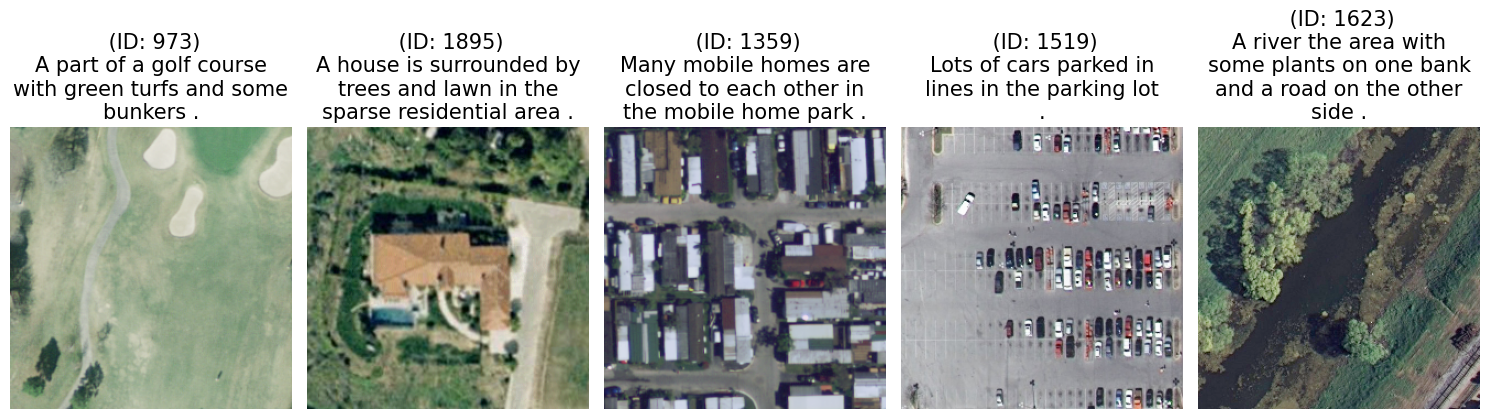

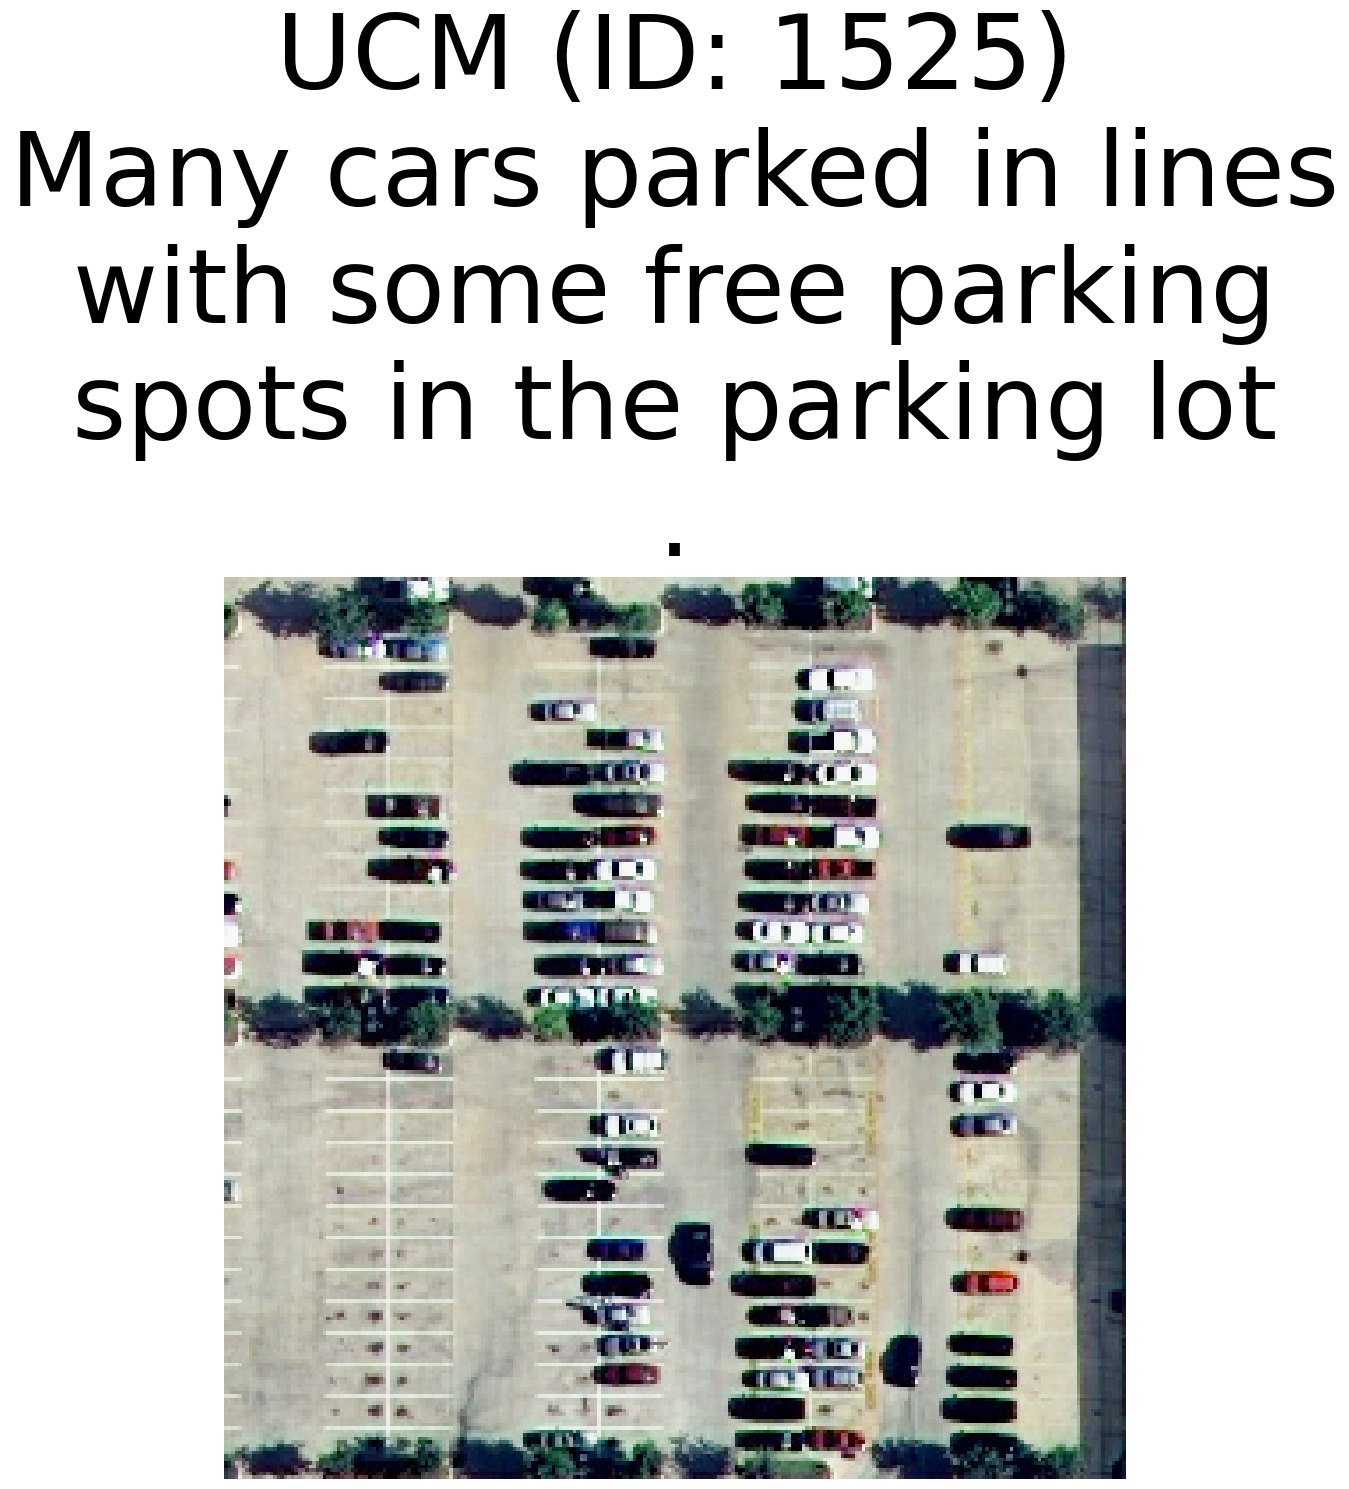

In [25]:
path = './data/UCM/'
img_folder = 'images'
json_file = 'dataset.json'
remote_sensing_stats(path, img_folder, json_file)
remote_sensing_stats(path, img_folder, json_file, num_examples = 1, save = 'UCM_example.png', dataset = 'UCM')

# RSICD

Number of images: 10921
Number of images: 10921


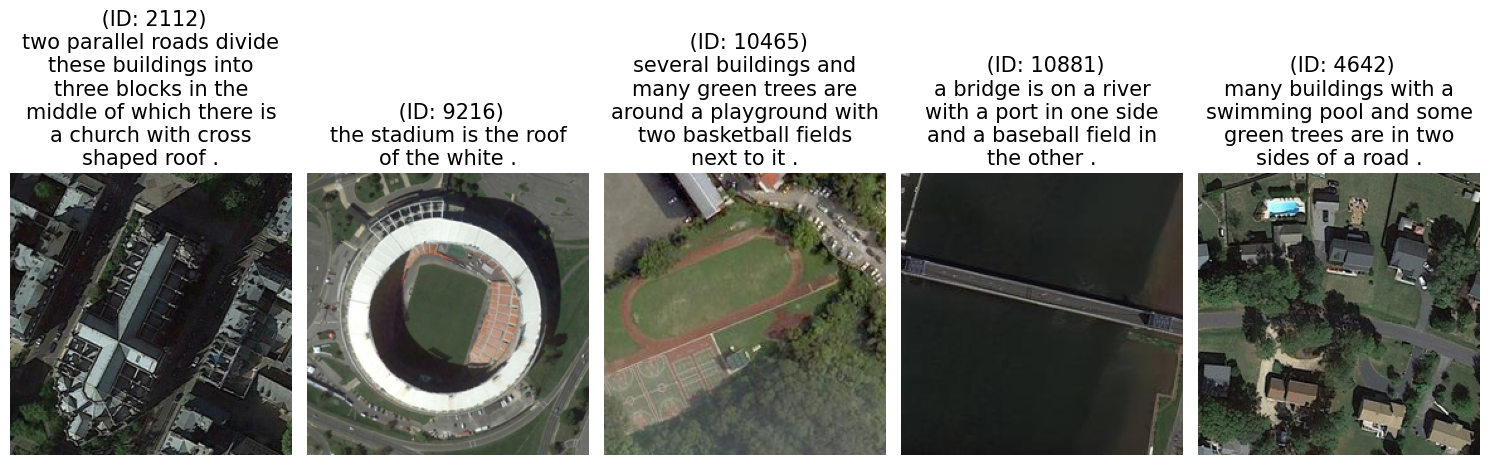

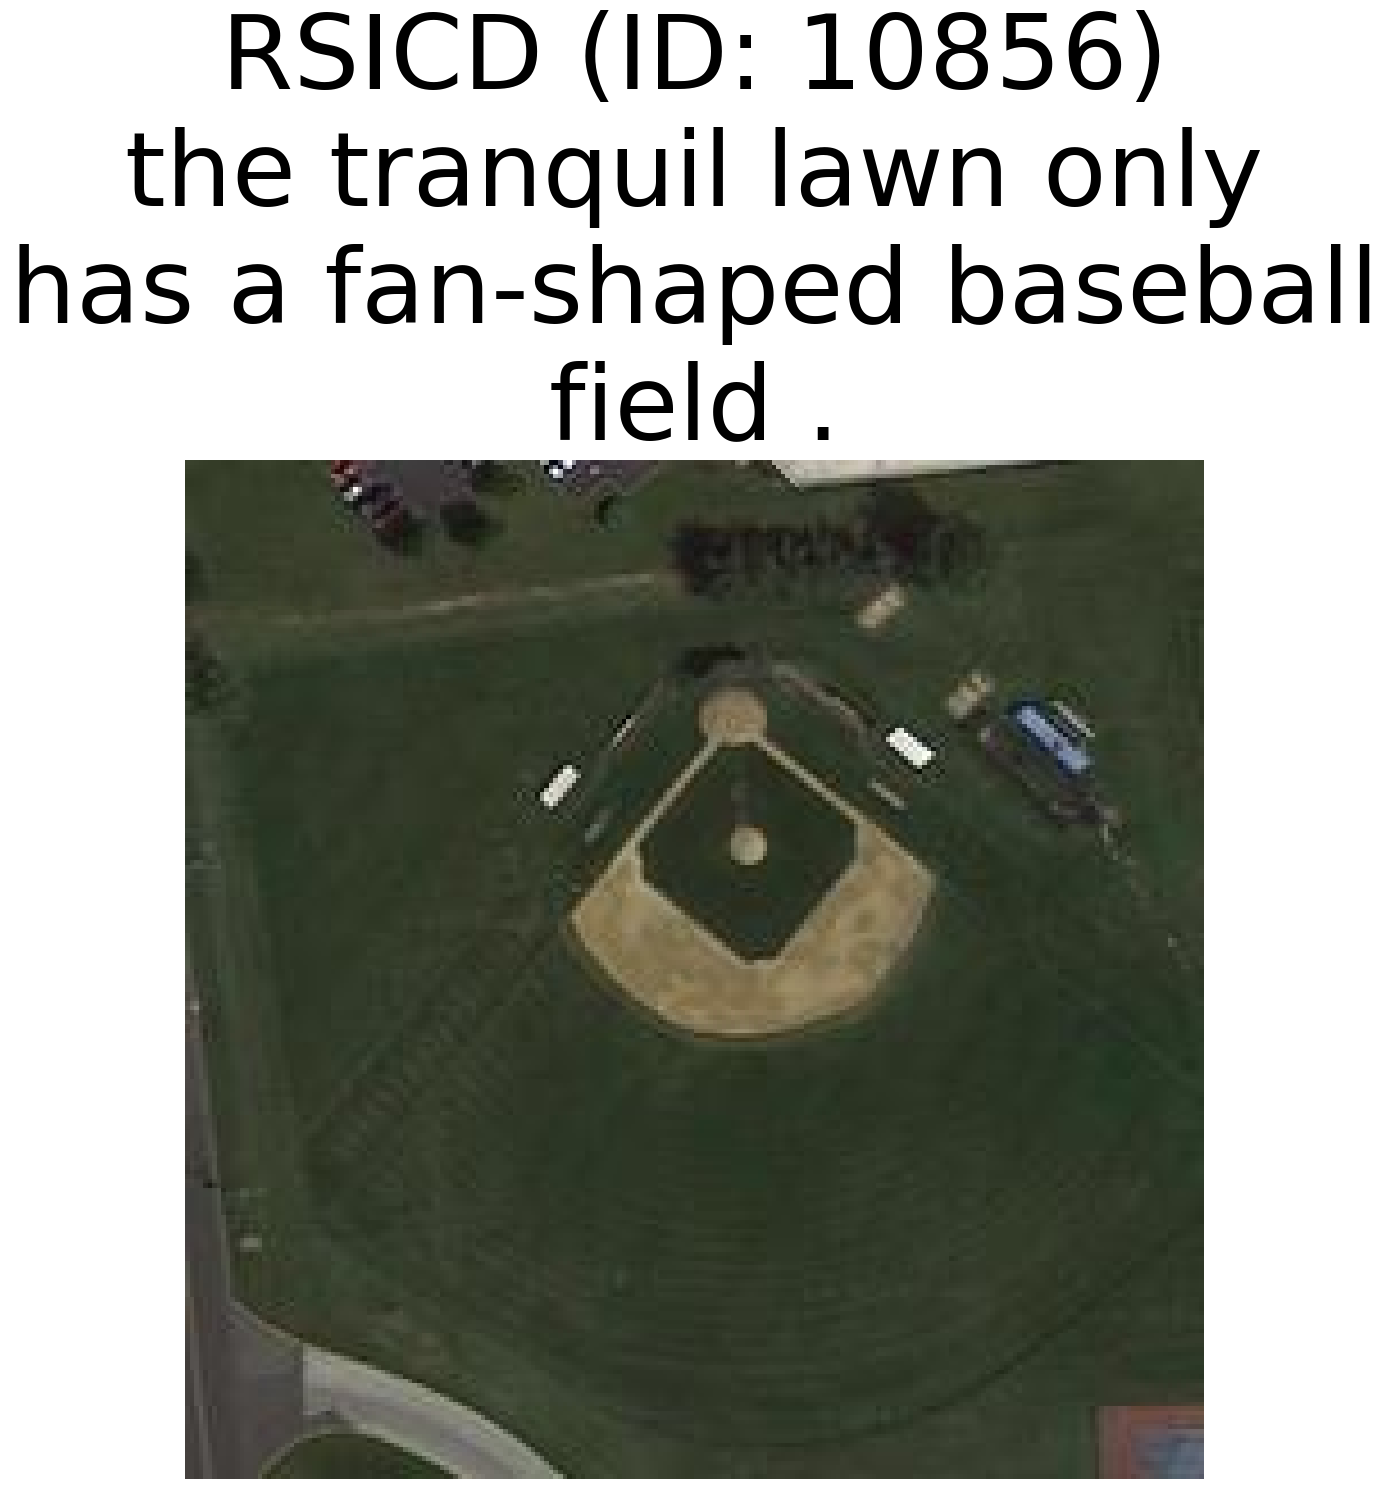

In [26]:
path =  './data/RSICD/'
img_folder = 'RSICD_images'
json_file = 'dataset_rsicd.json'
remote_sensing_stats(path, img_folder, json_file)
remote_sensing_stats(path, img_folder, json_file, num_examples = 1, save = 'RSICD_example.png' , dataset = 'RSICD')

# Sydney

Number of images: 613
Number of images: 613


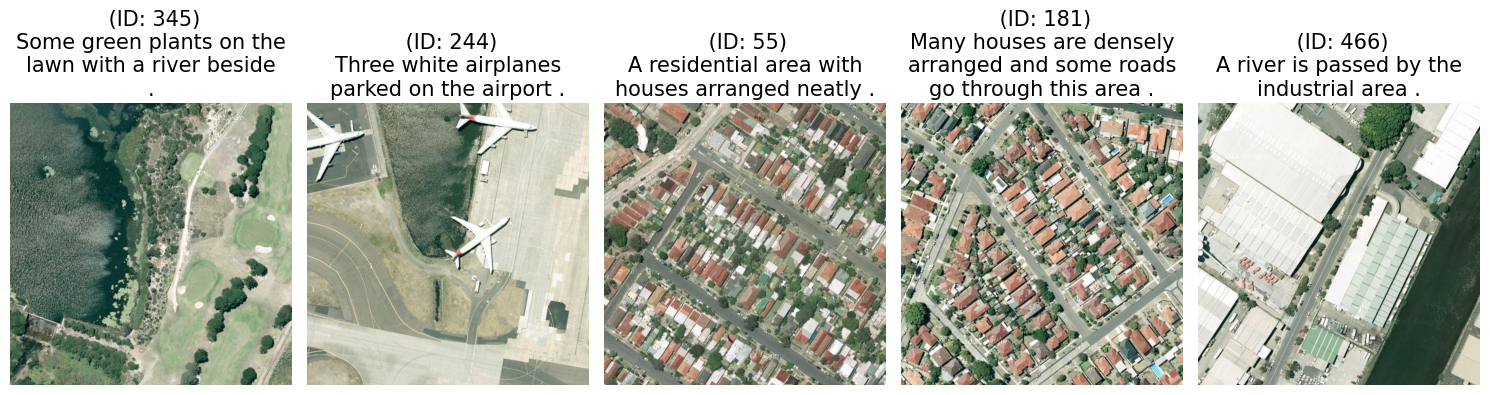

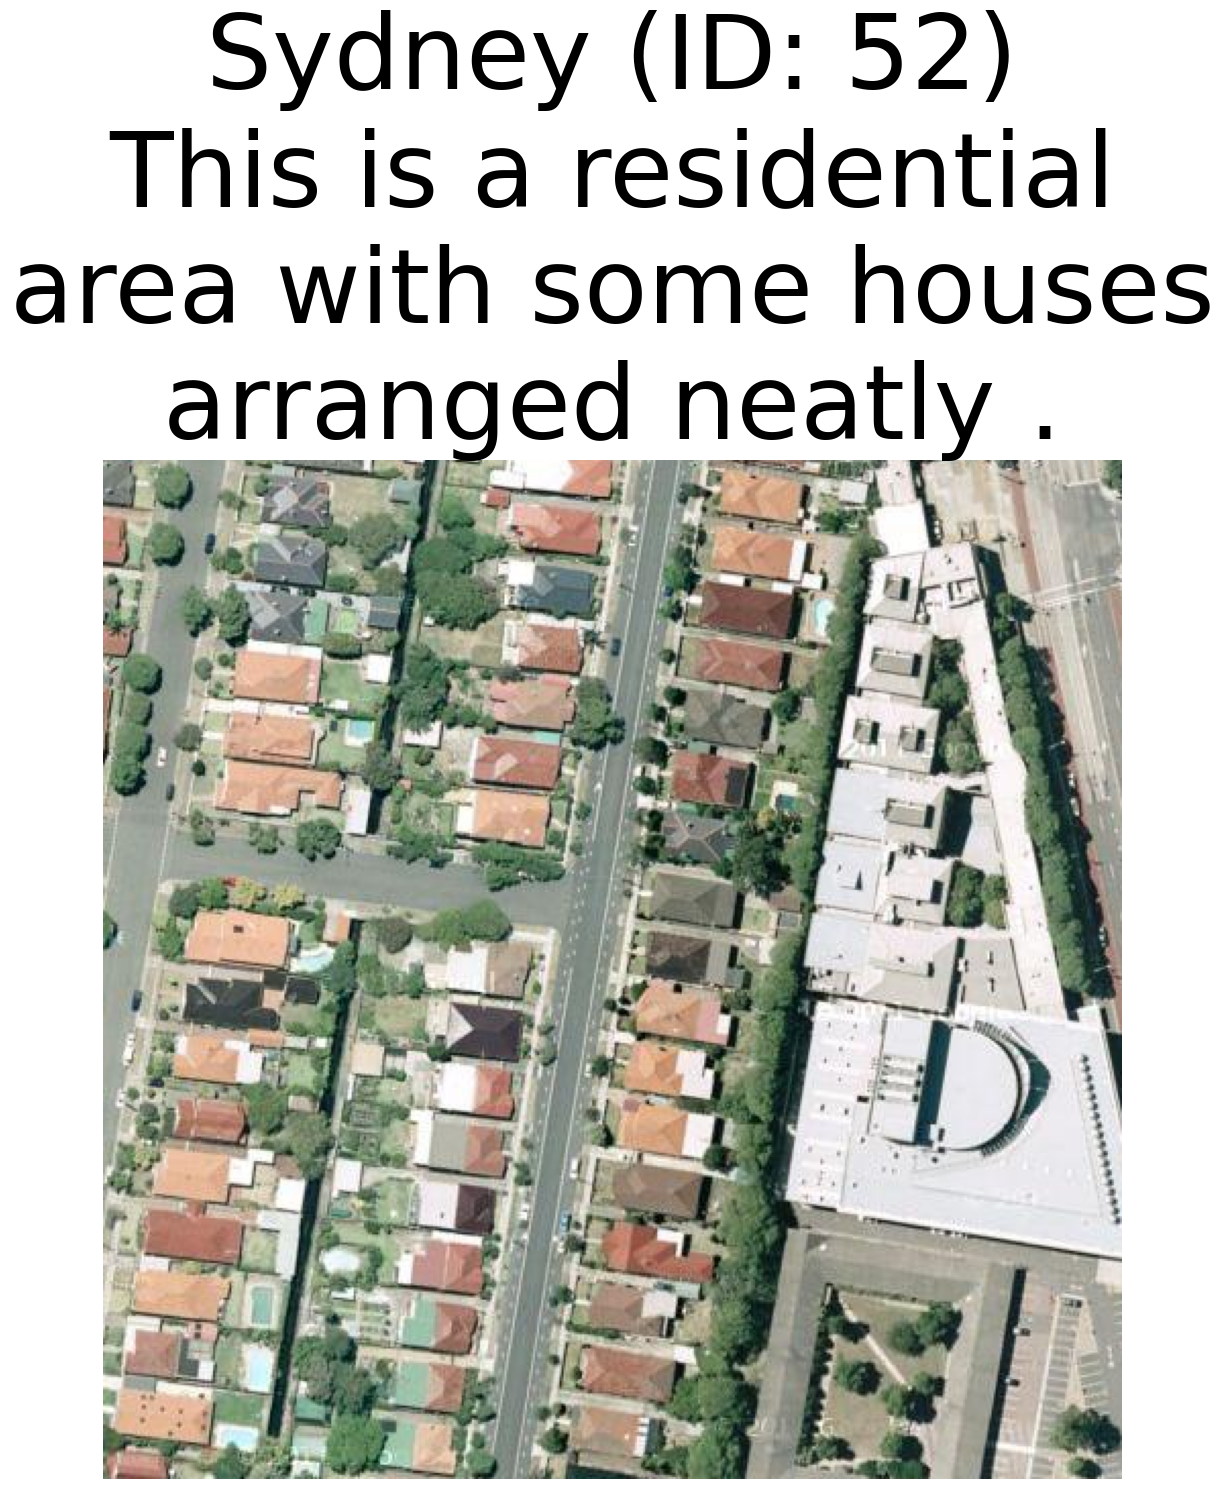

In [27]:
path = './data/sydney_captions/'
img_folder = 'images'
json_file = 'dataset.json'

remote_sensing_stats(path, img_folder, json_file)
remote_sensing_stats(path, img_folder, json_file, num_examples = 1, save = 'Sydney_example.png', dataset = 'Sydney')

# Simpsons

In [28]:
path = './data/kaggle_simpsons_characters/simpsons_dataset' # /kaggle_simpson_testset/kaggle_simpson_testset
os.listdir(path)

['abraham_grampa_simpson',
 'agnes_skinner',
 'apu_nahasapeemapetilon',
 'barney_gumble',
 'bart_simpson',
 'carl_carlson',
 'charles_montgomery_burns',
 'chief_wiggum',
 'cletus_spuckler',
 'comic_book_guy',
 'disco_stu',
 'edna_krabappel',
 'fat_tony',
 'gil',
 'groundskeeper_willie',
 'homer_simpson',
 'kent_brockman',
 'krusty_the_clown',
 'lenny_leonard',
 'lionel_hutz',
 'lisa_simpson',
 'maggie_simpson',
 'marge_simpson',
 'martin_prince',
 'mayor_quimby',
 'milhouse_van_houten',
 'miss_hoover',
 'moe_szyslak',
 'ned_flanders',
 'nelson_muntz',
 'otto_mann',
 'patty_bouvier',
 'principal_skinner',
 'professor_john_frink',
 'rainier_wolfcastle',
 'ralph_wiggum',
 'selma_bouvier',
 'sideshow_bob',
 'sideshow_mel',
 'snake_jailbird',
 'troy_mcclure',
 'waylon_smithers']